# Tail Greedy Treelet Algorithm

Comparison of treelet decomposition algorithm with tail greedy modification inspired by [`breakfast`](http://stats.lse.ac.uk/fryzlewicz/tguh/tguh.pdf) paper.

With the tail greedy modification at each level $l$ of the treel let $\alpha_l$ be the number of sum variables remaining and let $\rho$ be a parameter in $(0,1)$. The mofified algorithm performs up to $\left \lceil \rho \alpha_l \right \rceil$ simultaneous merges via Jacobi rotations. The first $\left \lceil \rho \alpha_l \right \rceil$ most correlated pairs are chosen, and the list is pruned allowing each sum variable to appear in at most one pair. 

## Setup

In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import numpy as np 
import pandas as pd
import sys
import os

In [2]:
sys.path.append("../scripts")
import python_treelet_implementation as pytree
import test_treelets_mixture_models as model
import tail_greedy_treelet as tail_greedy
import utils

## Comparison: linear mixture models

#### Uncorrelated factors and non-overlapping loading vectors 

The original paaper sets $\rho = 0.1$, with only 10 variables the this parameter choice could lead to the modified alfgorithm always behaving like the original; I therefore set $\rho$ = 0.5. The best three loading vectors are similar, though not identical, to those found by the original algorithm. The underlying factor structure is still identified. 

In [3]:
X = pd.read_csv("../data/3_uncorrelated_factors.csv").to_numpy()

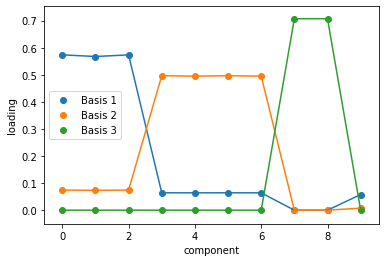

In [5]:
tree = tail_greedy.treelet_decomposition(X,.5)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]

utils.plot_loadings(loadings)

After the second itteration at each level in the tree only one merge is performed. 

Text(0, 0.5, 'merges')

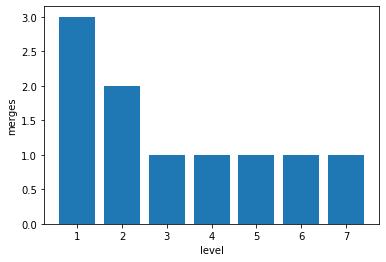

In [51]:
merges = []
for l in range(1,len(tree)): 
    merges += [len(tree[l]["pairs"])/2]
    
plt.bar(range(1,len(tree)),merges)
plt.xlabel("level")
plt.ylabel("merges")

#### Correlated factors and non-overlapping loading vectors 

Again I set $\rho = 0.5$. This the modified algorithm gives the same result as the original. The underlying factor structure is quite clear. 

In [6]:
X = pd.read_csv("../data/3_correlated_factors.csv").to_numpy()

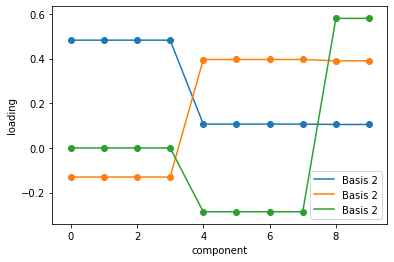

In [56]:
tree = tail_greedy.treelet_decomposition(X,.5)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]

utils.plot_loadings(loadings)

Again the number of merghes performed decreases as the algorithm moves up the tree. 

Text(0, 0.5, 'merges')

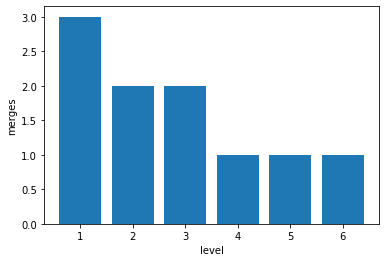

In [57]:
merges = []
for l in range(1,len(tree)): 
    merges += [len(tree[l]["pairs"])/2]
    
plt.bar(range(1,len(tree)),merges)
plt.xlabel("level")
plt.ylabel("merges")

#### Uncorrelated factors and overlapping loading vectors ($p<n$)

Here there are sufficiently many ($p=100$) variavles to justify setting $\rho = 0.1$. Again, the modified algorithm uncovers the underlying factor structure. Compared to the original algirithm the three maximum energy basis vectors give a soome what clearer picture of the underlying structure. 

In [22]:
X = pd.read_csv("../data/3_overlapping_vectors_low_dim.csv").to_numpy()

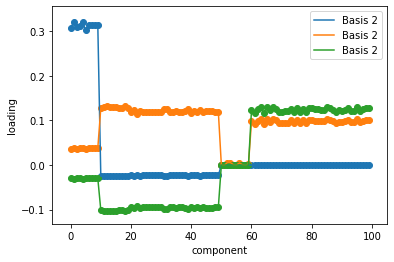

In [24]:
tree = tail_greedy.treelet_decomposition(X,.1)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]

utils.plot_loadings(loadings)

With more variables we now see that the the number of merges does not decay to zero as the algorithm moves up the tree.

Text(0, 0.5, 'merges')

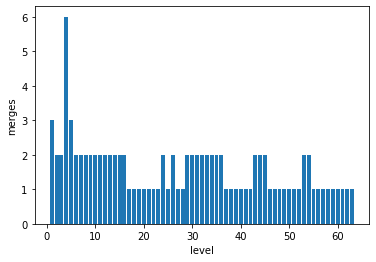

In [42]:
merges = []
for l in range(1,len(tree)): 
    merges += [len(tree[l]["pairs"])/2]
    
plt.bar(range(1,len(tree)),merges)
plt.xlabel("level")
plt.ylabel("merges")

#### Uncorrelated factors and overlapping vectors ($p>>n$)

Again I set $\rho = 0.1$. The modified algorithm returns the same best three loading vectors as the original.

In [58]:
X = pd.read_csv("../data/3_overlapping_vectors_high_dim.csv").to_numpy()

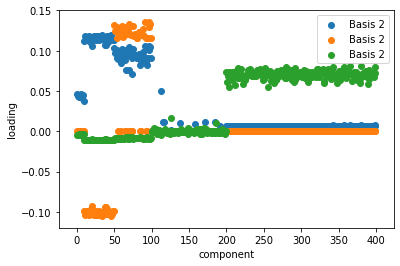

In [59]:
tree = tail_greedy.treelet_decomposition(X,.1)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]

utils.plot_loadings(loadings, joins = False)

The number of merges per itteration again does not decay to one. Not the higher number of variables merged towards the bottom of the tree, where most sum variables are untransformed, and at the top of the tree, where surviving sum variables are mostly weighted sums. 

Text(0, 0.5, 'merges')

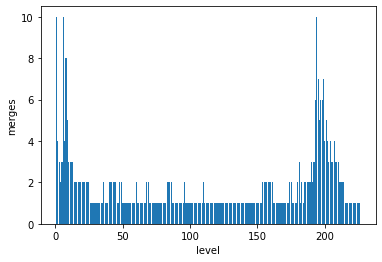

In [60]:
merges = []
for l in range(1,len(tree)): 
    merges += [len(tree[l]["pairs"])/2]
    
plt.bar(range(1,len(tree)),merges)
plt.xlabel("level")
plt.ylabel("merges")

## Comparison: real datasets

#### Crossett et al. genetic relationship data

The modified tree still reveals block structure in the covariance matrix; ths result seems to be robust to the choice of $\rho$. 

In [329]:
X = pd.read_csv("../data/Ahat.csv")\
    .drop("Unnamed: 0", axis = 1)\
    .to_numpy()

original_tree = pytree.treelet_decomposition(X, len(X))
greedy_tree = tail_greedy.treelet_decomposition(X, .1)

original_tree_order = []
for l in range(1,len(original_tree)):
    original_tree_order += original_tree[l]["pair"]

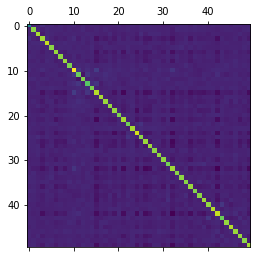

In [330]:
plt.matshow(greedy_tree[len(greedy_tree)-1]["C"])

In [331]:
param_values = np.arange(.01,1,0.01)
merges = []
order = []
tree_depth = []

In [332]:
for rho in param_values: 
    
    tree = tail_greedy.treelet_decomposition(X, rho)
    tree_merges = []
    tree_order = []
    for l in range(1,len(tree)): 
        tree_merges += [len(tree[l]["pairs"])/2]
        tree_order += tree[l]["pairs"]
        
    merges += [tree_merges]
    order += [tree_order]
    tree_depth += [len(tree)-1]

Tree deph decays exponentially in $\rho$. 

Text(0, 0.5, 'tree depth')

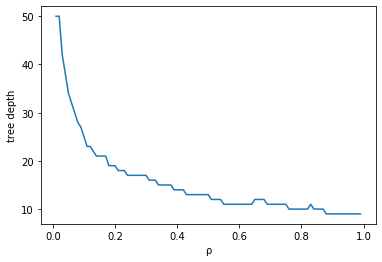

In [333]:
plt.plot(param_values, tree_depth)
plt.xlabel("ρ")
plt.ylabel("tree depth")

The number of merges also seems to decay exponentially with tree height. 

Text(0, 0.5, 'merges')

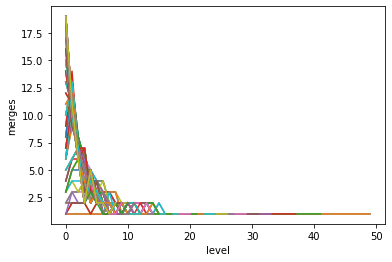

In [334]:
for i in range(len(param_values)):
    plt.plot(merges[i])
plt.xlabel("level")
plt.ylabel("merges")

The proportion of merges performed in the same order as the original algorithm also falls with $\rho$; this is interesting, as the disagreement does not prevent the tail greedy algorithm from discovering the same bblock structure in the data. Not the dip around $\rho = 0.7$. 

Text(0, 0.5, 'same merges (%)')

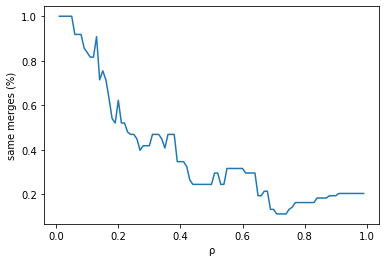

In [335]:
algorithm_agrrements = []
agreement_proportion = []
for l in range(len(order)): 
    algorithm_agrrements += [[True if order[l][i] == original_tree_order[i] else False
                              for i in range(len(original_tree_order))]]
for i in range(len(algorithm_agrrements)): 
    agreement_proportion += [sum(algorithm_agrrements[i])/len(algorithm_agrrements[i])]

plt.plot(param_values,agreement_proportion)
plt.xlabel("ρ")
plt.ylabel("same merges (%)")

The final plots examin when variable merges performed by the tail greed algorithm agree (+1) with the original and when they disagree (-1). The first plot is for the modified algorithm run with $\rho = 0.01$ - both algorithms agree always- while the second is for $\rho = 0.99$. 

Text(0, 0.5, 'agreement')

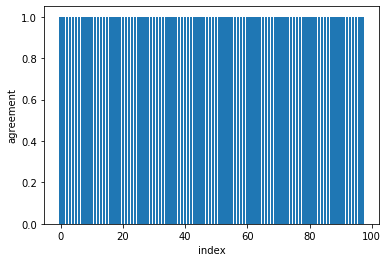

In [340]:
algorithm_agrrements = [[1 if order[0][i] == original_tree_order[i] else -1 for i in range(len(original_tree_order))]]
plt.bar(range(len(algorithm_agrrements[0])),algorithm_agrrements[0])
plt.xlabel("index")
plt.ylabel("agreement")

Text(0, 0.5, 'agreement')

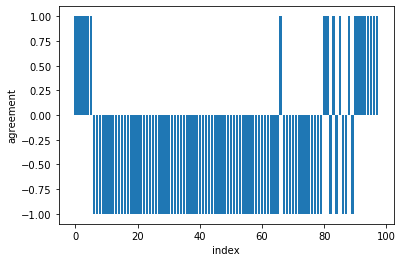

In [341]:
algorithm_agrrements = [[1 if order[98][i] == original_tree_order[i] else -1 for i in range(len(original_tree_order))]]
plt.bar(range(len(algorithm_agrrements[0])),algorithm_agrrements[0])
plt.xlabel("index")
plt.ylabel("agreement")